## Developing medical image analysis tools in Python with Scikit-image Workshop
### PyData Cambridge 14/11/2019
#### Author: Frank Longford

This notebook will guide users through a tutorial that will explore the scikit-image library to construct a pipeline for medical image analysis.

Our aim is to derive a set of operations that will both automatically segment and analyse a microscope slide.

First we import all necessary packages, including NumPy and Matplotlib, and a couple of useful plotting functions from our local `plotting` library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from plotting import plot_image, plot_image_and_hist

%matplotlib inline

## Importing an Image

If importing an image from file, use the `skimage.io.imread` function, which has pretty versitile file format handling (uses `pil` / `matplotlib` / `tiffile` loaders). If importing an image which is not in hexadecimal format (high colour resolution), then it is probably preferred to load it in as a NumPy array.

Inside the repository you will find an file named `cell_example.tif`, complete the cell below to load in the image and view it.

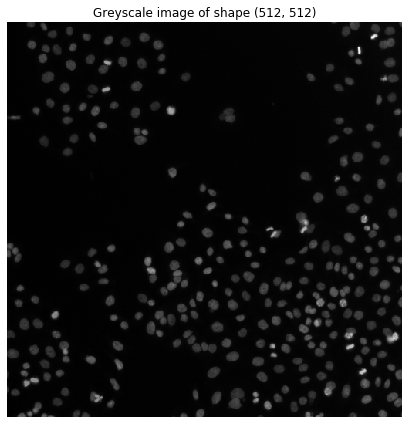

In [2]:
from skimage.io import imread
# Import the cell_example.tif file usingskimage.io.imread function

image = imread("cell_example.tif")

plot_image(image)

Here we see a grayscale image of a microscpe slide containing a number of cells. Before looking at this image we can already tell that it is in grayscale format due to the shape (512, 512).

For the rest of this tutoral we shall use the `skimage.data.immunohistochemistry` example resource, which is supplied along with other demo images in the `skimage.data` module.

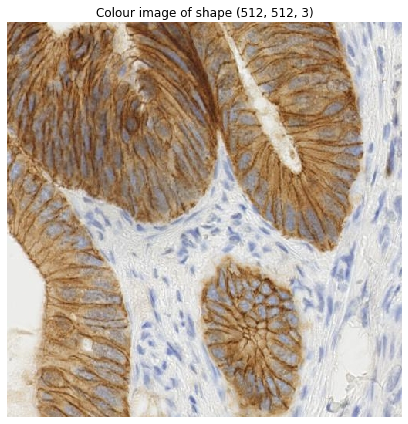

In [3]:
from skimage.data import immunohistochemistry
# Import an example image using the skimage.data.immunohistochemistry function 

rgb_image = immunohistochemistry()

plot_image(rgb_image)

Here we see a colour image of a microscpe slide demonstrating immunohistochemical (IHC) stained cells. Before looking at this image we can already tell that it is in RGB format due to the shape (512, 512, 3). We are able to convert between RGB and grayscale formats using the `skimage.color.rgb2gray` conversion tool.

In [ ]:
from skimage.color import rgb2gray
# Convert the color image to grayscale using the skimage.color.rgb2gray function

grayscale = rgb2gray(rgb_image)

plot_image([rgb_image, grayscale])

## Pre-processing

We can apply some operations to both grayscale and RGB versions of our image. These typically include

1) Filtering

2) Equalization

3) Restoration

Throughout this section will shall refer to the greyscale image as $f(x, y)$.

### Filtering

Filtering is typically achived by performing a convolution of the entire image using another function $h(x, y)$.

$g(x, y) = h(x, y) * f(x, y) = \int\limits_{s=-\infty}^\infty\int\limits_{t=-\infty}^\infty h(s, t) f(x + s, y + t) \:ds\:dt$

One of the most common filters uses a Gaussian function to perform this convolution. In which case, we also need to provide a value for the standard deviation $\sigma$ of the distribution.

$h(x, y, \sigma) = \frac{1}{2\pi\sigma^2} \exp\left[-\frac{x^2 + y^2}{2\sigma^2}\right]$

Below we apply the `skimage.filters.gaussian` function to our RGB and grayscale images. The only extra information that we should supply to the function for an RGB image is to set the keyword argument `multichannel=True`, so that `gaussian` interprets the format of the NumPy array accordingly.

In [ ]:
from skimage.filters import gaussian
# Smooth both RGB and grayscale images using the skimage.filters.gaussian filter

smooth_rgb_image = gaussian(rgb_image, sigma=3, multichannel=True)
smooth_grayscale = gaussian(grayscale, sigma=3)

plot_image_and_hist([rgb_image, smooth_rgb_image, grayscale, smooth_grayscale],
                    ['Original Colour', 'Gaussian smoothed',
                     'Original Greyscale', 'Gaussian Smoothed'])

#### Kernel Filtering

Kernel filtering, or smoothing can be performed by performing a convolution over a region around each pixel with an applied matrix (or kernel) $\omega$ that defines the weight contributions of each pixel in the region.

$g(x, y) = \omega(x, y) * f(x, y) = \sum\limits_{s=-a}^a\sum\limits_{t=-b}^b \omega(s, t) f(x - s, y - t)$

For example, calculating the mean value for a 3 x 3 region around each pixel is the equivalent of applying a mean filter using the kernel matrix:

$\omega = \frac{1}{9} \left(\begin{array}{lll} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{array}\right)$

For RGB images, the convolution is performed in each channel independently. 

In scikit-image, most kernel filters are located in the `skimage.filters.rank` module, whilst binary objects that define the shape of the kernels themselves (termed `selem`) are contained in the `skimage.morphology` module. In the example above, the selem would contain a 3 x 3 square matrix where each value is set to 1. The filter function (in this case, then mean) is then performed on top of this selem, which leads to the form of $\omega$ provided. If we wanted to use a different mean kernel that only included pixels within a certain radian integer distance (shown below), we can use the `disk` selem instead, resulting in the following equivalent expression for $\omega$:

$\omega = \frac{1}{5} \left(\begin{array}{lll} 0 & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 0 \end{array}\right)$ 

In reality, a selem is just a binary NumPy array - additional selems found in the `skimage.morphology` module include `rectangle` and `star`, but you can also contribute any NumPy Array.

In [ ]:
from skimage.morphology import square, disk, rectangle

square_selem = square(3)
disk_selem = disk(2)
rectangle_selem = rectangle(4, 3)

print("{} \n {} {} \n".format(square_selem, type(square_selem), square_selem.dtype))
print("{} \n {} {} \n".format(disk_selem, type(disk_selem), disk_selem.dtype))
print("{} \n {} {} \n".format(rectangle_selem, type(rectangle_selem), rectangle_selem.dtype))

An example of how different filters can affect the pixel intensity distribution of our image is given below. Here we apply the `skimage.filters.rank.mean`, `skimage.filters.rank.median` and `skimage.filters.rank.mean.bilateral` filters, using the same selem `disk(5)`.

The Bilateral Mean filter is particulary useful, as it is able to retain the contrast between different areas of detail whilst also reducing the overall noise. This is achieved by including the intensity as an extra component in $\omega$ that takes into account the difference in pixel intensities. 

In [ ]:
from skimage.filters.rank import mean, median, mean_bilateral
# Use a selem of your choice to perform mean, median and bilateral kernel 
# filtering on our grayscale image

selem = disk(8)

mean_filter = mean(grayscale, selem)
median_filter = median(grayscale, selem)
bilateral_mean_filter = mean_bilateral(grayscale, selem)

plot_image_and_hist([grayscale, mean_filter,
                     median_filter, bilateral_mean_filter],
                    ['Original Image', 'Mean Filter',
                     'Median Filter', 'Bilateral Mean Filter'])

### Equalisation

Often an image may suffer from under or over exposure, leading to an imbalance in contrast. Shot-noise may also lead to certain pixels having an artifically high or low intensity, which will affect any derivative-derived properties. Equalization of an image's pixel distribution can provide a way to remove such artefacts.

The next cell creates an artificially over-exposed image by applying a Gaussian function located on the centre pixel

In [ ]:
from scipy import signal
from skimage.exposure import rescale_intensity

def normalise(array):
    """Normalises all values in an array to lie between 0-1"""
    lower, upper = np.percentile(array, (0, 100))
    
    normalised = rescale_intensity(array, in_range=(lower, upper))
    
    return normalised

def gaussian_kernel(kernlen=21, std=3):
    """Returns a 2D Gaussian kernel array."""
    
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    
    gkern2d = np.outer(gkern1d, gkern1d)
    
    return gkern2d


imbalanced = grayscale * (1 + 0.5 * gaussian_kernel(grayscale.shape[0], std=50))

imbalanced = normalise(imbalanced)

One way to rescale the intensities with the `rescale_intensity` function to lie with the range of 2-98% of thier original values. This will remove the extrema values, resulting in a more even distribution at the loss of some local details.

A slightly more intelligent equalisation method is to rescale the intensities until they yeild a linear culumative distribution function, which can be performed by calling `equalize_hist`. Again, this is performed on the entire image and so some local detail can be lost. Alternatively, the adaptive equalization routine `equalize_adapthist` performs the same procedure, yet over a specified local kernel (the shape of which can be set using the `kernel_size` keyword argument). Therefore the global intensity distribution will not be linear and some local features will be retained. This is particulary useful if we have an exposure imbalance in an image, leading to some areas being lighter than others.

In [ ]:
from skimage.exposure import equalize_adapthist, equalize_hist
# Complete the cell by using the rescale_intensity, equalize_adapthist and equalize_hist
# functions. In order to get the pixel values that represent 2% and 98% of the overall
# distribution, we typically use the np.percentile function (see cell above)

# Contrast stretching
p2, p98 = np.percentile(imbalanced, (2, 98))
img_rescale = rescale_intensity(imbalanced, in_range=(p2, p98))

# Equalization
img_eq = equalize_hist(imbalanced)

# Adaptive Equalization
img_adapteq = equalize_adapthist(imbalanced, kernel_size=(16, 16))

plot_image_and_hist([imbalanced, img_rescale, img_eq, img_adapteq],
                    ['Low contrast image', 'Contrast stretching',
                     'Histogram equalization', 'Adaptive equalization'])

### Restoration

One extra state-of-the-art filtering method in scikit-image is the non-local means algorithm, which attempts to restore features of an image that may have been lost due to noise.

The next cell creates an artificially noisy image by applying a Gaussian distribution of random values using a standard deviation of 0.1.

In [ ]:
from skimage.util import random_noise

sigma = 0.1

noisy_image = random_noise(rgb_image, var=sigma**2)

The non-local means algorithm works in a similar way to the bilateral mean, whereby the local mean of each pixel is first calculated for a given kernel $\omega(x, y)$ as $\mathbf{B}(x, y)$. 

$\mathbf{B}(x, y) = \sum\limits_{s=-a}^a\sum\limits_{t=-b}^b \omega(s, t) f(x - s, y - t)$

A Gaussian convolution is then performed using the difference in pixel intensities of $\mathbf{B}(x, y)$ to calculate the weights,

$h(x, y, s, t) = \exp\left[-\frac{|\mathbf{B}(x - s, y - t)- \mathbf{B}(x, y)|^2}{\sigma^2}\right]$

so that the full convolution is given by,

$g(x, y) = \frac{1}{C(x, y)}\int\limits_{s=-\infty}^\infty\int\limits_{t=-\infty}^\infty h(x, y, s, t) f(x - s, y - t) \:ds\:dt$

with a normalisaing factor

$C(x, y) = \int\limits_{s=-\infty}^\infty\int\limits_{t=-\infty}^\infty h(x, y, s, t) \:ds\:dt$

In reality, the integrals shown above are performed as partial integrals over local region around each pixel. As a rule of thumb, the size of these integrals can be estimated from the amount of noise in the image. The `skimage.restoration.estimate_sigma` function can provide an estimation of the standard deviation of noise, assuming a normal distribution (white noise).

The code below performs the non-local means algorithm using a square kernel of size `patch_size` for calculating $\mathbf{B}(x, y)$, a partial integral cutoff of length `h`, and a Gaussian standard deviation $\sigma$ of `sigma`. An appropriate value for the cutoff length can normally be estimated as between 0.5-1.0 $\sigma$.

In [ ]:
from skimage.restoration import estimate_sigma, denoise_nl_means
# Complete the cell to apply the skimage.restoration.denoise_nl_means algorithm to our
# noisy_image. Try to estimate the appropriate value of sigma to use from the
# estimate_sigma function

sigma_est = estimate_sigma(noisy_image, multichannel=True)

sigma_est = np.mean(sigma_est)

print('Actual noise std: {}  Estimated noise std = {}'.format(sigma, sigma_est))

restored_image = denoise_nl_means(
    noisy_image, patch_size=5, h=0.6 * sigma_est, 
    sigma=sigma_est, fast_mode=True, multichannel=True)

plot_image_and_hist([rgb_image, noisy_image,
                     restored_image],
                    ['Original Image', 'Noisy Image',
                     'Non-local Means'])

In general, pre-processing can be very useful and there are plenty of options readily available in scikit-image. We shall also see how these pre-processing operations can affect the performance of other algorithms. 

## Gradient Analysis

Let's now explore some of the structural details of this greyscale image using the `skimage.feature.structure_tensor` and `skimage.feature.hessian_matrix` routines. Both use numerical estimates of the derivates of $f(x, y)$ to extract properties of the image, in the same way we might investigate propertes of a surface.

### Structure Tensor

Using our greyscale, single channel image, $f(x, y)$, we can examine the structure tensor to obtain information on the primary derivatives (the Jacobian $\mathbf{J}(x, y)$).

$\mathbf{J}(x, y) = \left[\frac{\partial f(x, y)}{\partial x}, \frac{\partial f(x, y)}{\partial y}\right]$

Generally the estimation of each derivative is computed by the Sobel transform

$\mathbf{J}(x, y) \approx \left[\omega(x, y) * f(x, y),\; \omega^{\mathbf{T}}(x, y) * f(x, y)\right]$

where

$\omega = \begin{bmatrix} 
 -1 & 0 & +1  \\
-2 & 0 & +2 \\
-1 & 0 & +1 
\end{bmatrix}$

In [ ]:
from skimage.filters import sobel_h, sobel_v

jacobian = [sobel_h(grayscale), sobel_v(grayscale)]

plot_image(jacobian, titles=[r'$\mathbf{J}_{x}(x, y)$', r'$\mathbf{J}_{y}(x, y)$'])

The structure tensor $\mathbf{A}(x, y)$ is defined as

$\begin{align} 
    \mathbf{A}(x, y) &= \mathbf{J}(x, y) \cdot \mathbf{J}^{\mathbf{T}}(x, y) \\
    &= \left[\begin{array}{cc} 
        \mathbf{J}_{x}(x, y)^2 & \mathbf{J}_{x}(x, y)\mathbf{J}_{y}(x, y) \\
        \mathbf{J}_{x}(x, y)\mathbf{J}_{y}(x, y) & \mathbf{J}_{y}(x, y)^2
    \end{array}\right]
\end{align}$

Therefore we can see that there are only 3 unique elements in this 2 x 2 tensor, $\mathbf{A}_{xx}(x, y)$, $\mathbf{A}_{xy}(x, y)$ and $\mathbf{A}_{yy}(x, y)$

The function `skimage.feature.structure_tensor` calculates the unique elements of $\mathbf{A}(x, y)$ using the Sobel transform, wilst also applying a Gaussian filter to each element.

In [ ]:
from skimage.feature import structure_tensor

structure = structure_tensor(grayscale, sigma=0.1, mode='reflect')

plot_image(structure,
           titles = [r'$\mathbf{A}_{xx}(x, y)$',
                     r'$\mathbf{A}_{xy}(x, y)$',
                     r'$\mathbf{A}_{yy}(x, y)$'],
           cmap=plt.cm.gray_r)

The eigenvalues $\lambda_{max}$, $\lambda_{min}$ and eigenvectors $e_{max}$, $e_{min}$ of the structure tensor can be interpreted as summaraising the distribution of gradients centered on pixel $x, y$. 

The anisotropy (or coherence) in gradient directions can be interpreted from the difference in eigenvalues,

$n(x, y) = \left(\frac{\lambda_{max} - \lambda_{min}}{\lambda_{max} + \lambda_{min}}\right)^2$

with the overall direction is defined in terms of the Jacobian, 

$\theta(x, y) = \arctan\left(\frac{\mathbf{J}_{y}(x, y)}{\mathbf{J}_{x}(x, y)}\right)$

and the energy is defined in terms of the trace of the structure tensor

$\psi(x, y) = \sqrt{{A}_{xx}(x, y) + {A}_{yy}(x, y)}$

In [ ]:
from skimage.feature import structure_tensor_eigvals

def structure_properties(image):
    # Complete the function to return the anisotropy, angle, energy
    # values for each pixel in our image argument using the definitions
    # above

    image = normalise(image)
    
    jacobian = [sobel_h(image), sobel_v(image)]
    structure = structure_tensor(image, sigma=0.5, mode='reflect')
    
    eig_val = structure_tensor_eigvals(*structure)
    eig_diff = (eig_val[0] - eig_val[1])
    eig_sum = eig_val[0] + eig_val[1]

    anisotropy = np.divide(eig_diff, eig_sum)**2
    angle = np.arctan(*jacobian)
    energy = np.hypot(*jacobian)

    return anisotropy, angle, energy


anisotropy, angle, energy = structure_properties(grayscale)

plot_image([anisotropy, angle, energy], titles=['Anisotropy', 'Angle', 'Energy'], cmap=plt.cm.gray_r)

We can see that using the first derivatives can provide information on 'edge' like regions.

### Hessian Tensor

Using our greyscale, single channel image, $f(x, y)$, we can examine the hessian tensor to obtain information on the secondary derivatives (the Hessian $\mathbf{H}(x, y)$).

$\mathbf{H}(x, y) = \left[\begin{array}{cc} 
    \frac{\partial^2 f(x, y)}{\partial x^2} & \frac{\partial^2 f(x, y)}{\partial y\partial x} \\
    \frac{\partial^2 f(x, y)}{\partial x\partial y} & \frac{\partial^2 f(x, y)}{\partial y^2}
\end{array}\right]$

In scikit-image, the secondard derivatives are estimated using a forward / backward approximataion (from `numpy.gradient`). Since the x and y components are treated as independent, again we can see that there are only 3 unique elements to this 2 x 2 tensor, $\mathbf{H}_{xx}(x, y)$, $\mathbf{H}_{xy}(x, y)$ and $\mathbf{H}_{yy}(x, y)$. These are computed using the `skimage.feature.hessian_metrix` function.



In [ ]:
from skimage.feature import hessian_matrix

hessian = hessian_matrix(grayscale, sigma=0.5)

plot_image(hessian, 
           titles = [r'$\mathbf{H}_{xx}(x, y)$',
                     r'$\mathbf{H}_{xy}(x, y)$',
                     r'$\mathbf{H}_{yy}(x, y)$']
           cmap=plt.cm.gray_r)

Using the second derivates can be interpreted as providing information on the curvature of the image. Therefore, they can be very useful to identify and enhance 'ridge' like regions, such as vessels, wrinkles or tubes.

The Sato (or "tubeness") filter calculates the eigenvalues of the Hessian tensor for each pixel and applies a threshold method (in 2D)

$T(x, y) = \left\{\begin{array}{lll} |\lambda_{min}| & \text{if} & \lambda_{min} < 0 \\ 0 & \text{else} & \end{array} \right.$

In scikit-image, the `skimage.filters.sato` function includes the option to calculate $T(x,y)$ for a range of Gaussian filters with varying $\sigma$. The final outcome for each pixel is then provided by the maximum value of $T(x, y)$ calculated across all filters.

In [ ]:
from skimage.filters import sato
# Appliy the skimage.filters.sato function to our grayscale image, whilst
# varying the sigmas keyword argument (list of floats)

tubeness = sato(grayscale, black_ridges=False)

plot_image([grayscale, tubeness], ['Original Image', 'Sato Filter'])

## Segmentation

Robust automatic segmentation of images is a highly desired outcome of any analysis pipeline. 

Filters are generally one of the first operations performed on an image to prepare it for segmentation. In the simplest of cases, identifying the edges of the image can provide enough information to form the boundary of each segment.

The Canny filter uses both the angle and energy of each pixel to perform an edge finding algorithm and involves a Gaussian filter to 'wash out'  minor gradients, allowing only the larger features to be extracted. It is generally a good first choice when exploring different boundary finding filters. In sckit-image, it can be found in the `skimage.feature.canny` module.

In [ ]:
from skimage.feature import canny
# Use the skimage.feature.canny fucntion to identify edges in our grayscale
# image - play about with the value of Gaussian sigma to see how this affects the outcome
canny_edges = canny(grayscale, sigma=1.5)

plot_image([grayscale, canny_edges])

After identifying edges, we can fill in the areas between them to create binary regions.

In [ ]:
from scipy.ndimage import binary_fill_holes
from skimage.morphology import binary_closing

closed = binary_closing(canny_edges, selem=disk(2))

binary_mask = binary_fill_holes(closed)

plot_image([grayscale, canny_edges, binary_mask],
          ['Original Image', 'Canny Filter', 'Binary Mask'])

The `skimage.measure.label` algorithm can then be used to label each connected region in a binary image. It returns a new array with an integer label for each pixel in the image representing the segement that it belongs to. Each segment is made up from pixels containing a binary value of 1 that are connected together spatially. The distance with which pixels are connected and therefore considered 'neighbours' can be altered using the `connectivity` keyword argument.

In [ ]:
from skimage.measure import label
from skimage.color import label2rgb
# Apply the skimage.measure.label algorithm to oour binary_mask. Experiement
# with varying the value of the connectivity keyword argument to form labelled segments

label_image = label(binary_mask)

image_label_overlay = label2rgb(label_image, image=grayscale, bg_label=0)

plot_image(image_label_overlay)

This is a typical method to segment regions in images. Once a label image has been created, the `skimage.measure.regionprops` algorithm can be used to create a list of `RegionProperties` objects representing each segment. These objects have attributes providing metrics to describe the segment's content, size and shape. The keyword argument `intensity_image` can also be used to provide the original image as a reference.

In [ ]:
from skimage.measure import regionprops
# Apply the skimage.measure.regionprops algorithm to the label_image array
# in order to extract a list of RegionProperties object describing each segment.

regions = regionprops(label_image, intensity_image=grayscale)

regions = [region for region in regions if region.area > 200]

plot_image([region.intensity_image for region in regions],
           [f'Region #{region.label}' for region in regions])

## Color Based Segmentation

Assuming that the color in stained microscope slides is relatively consistent, we can also attempt to cluster each pixel in an RGB image by its hue (unit RGB vector).

This can be performed by using machine learning clustering algorithims supplied in the scikit-images library. Alternatively, scikit-image has some inbuilt tools to provide assistance for certain microscope stain patterns. The `skimage.color.seperate_strains` function contains many different conversion options to transform each channel into weightings representing the concentration of dye in each color stain.

This conversion is performed as a matrix multiplication of each RGB vector with the generic form shown below, that is derived from the Beer-Lambert Law describing intensity of light from chemical concentrations. Here we represent our RGB image as $\mathbf{I}(x, y)$, since we now possess a vector for each pixel, and our conversion operation $\mathbf{A}$ is a normalised 3 x 3 matrix.

$\mathbf{G}(x, y) = -  \mathbf{A}\log{\left(\mathbf{I}(x, y)\right)}$

Conversions for microscope stains currently included in scikit-image include:

1. Hematoxylin + Eosin + DAB
2. Hematoxylin + DAB
3. Feulgen + Light Green
4. Giemsa stain : Methyl Blue + Eosin
5. FastRed + FastBlue +  DAB
6. Methyl Green + DAB
7. Hematoxylin + AEC
8. Blue matrix Anilline Blue + Red matrix Azocarmine + Orange matrix Orange-G
9. Methyl Blue + Ponceau Fuchsin
10. Alcian Blue + Hematoxylin
11. Hematoxylin + PAS

In [ ]:
from skimage.color import separate_stains, hed_from_rgb
from matplotlib.colors import LinearSegmentedColormap

# Create an artificial color close to the original one
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white',
                                             'saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet',
                                               'white'])

smoothed = gaussian(rgb_image)

hed_image = separate_stains(smoothed, hed_from_rgb)

fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(rgb_image)
ax[0].set_title("Original image")

ax[1].imshow(hed_image[:, :, 0], cmap=cmap_hema)
ax[1].set_title("Hematoxylin")

ax[2].imshow(hed_image[:, :, 1], cmap=cmap_eosin)
ax[2].set_title("Eosin")

ax[3].imshow(hed_image[:, :, 2], cmap=cmap_dab)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

Here we can clearly see that we can use the DAB stain to segment the cellualr regions from this image

In [ ]:
from skimage.measure import label
from skimage.color import label2rgb

def get_labels(mask):
    
    # Again, we fill in any holes for each region we shall segment
    closed = binary_closing(thresholded, disk(3))

    filled = binary_fill_holes(closed)

    # label image regions
    label_image = label(filled)
    
    return label_image


# We use the channel that corresponds to the DAB color in our IHC stained image
dab_image = hed_image[:, :, 2]

# Here we threshold the image to remove the background
thresholded = dab_image > threshold_isodata(dab_image)

# label image regions
dab_label_image = get_labels(thresholded)

image_label_overlay = label2rgb(dab_label_image, image=grayscale, bg_label=0)

plot_image([rgb_image, image_label_overlay])

## Extension

More information about textures can be obtained using grey level correlation matricies (GLCM)

In [ ]:
# We use the channel that corresponds to the Hema color in our IHC stained image
hema_image = hed_image[:, :, 0]

# Here we threshold the image to remove the background
thresholded = (hema_image > threshold_isodata(hema_image)) * (dab_image < threshold_isodata(dab_image))

# label image regions
hema_label_image = get_labels(threshold)

image_label_overlay = label2rgb(hema_label_image, image=grayscale, bg_label=0)

plot_image([rgb_image, image_label_overlay])

In [ ]:
regions = regionprops(hema_label_image, intensity_image=grayscale)

# compute some GLCM properties each patch
xs = []
ys = []
for region in regions:
    #xs.append(region.eccentricity)
    
    int_image = (region.intensity_image * 255).astype(int)
    glcm = greycomatrix(int_image, [1, 2], [0, np.pi/4, np.pi/2, np.pi*3/4], 256,
                        symmetric=True, normed=True)
    glcm[0, :, :, :] = 0
    glcm[:, 0, :, :] = 0
    
    xs.append(greycoprops(glcm, 'dissimilarity').mean())
    ys.append(greycoprops(glcm, 'correlation').mean())
    
plt.scatter(xs, ys)
plt.show()